<a href="https://colab.research.google.com/github/PrintfPeng/Allforone/blob/main/FinalAIDurian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==== 0) Setup & Mount Drive ====
from google.colab import drive
drive.mount('/content/drive')

# ---- ปรับ path ให้ตรงกับของคุณ ----
DATASET_ROOT = '/content/drive/MyDrive/DATASET_DURIAN_LEAF_CLASSIFY'  # มี train/val/test อยู่ข้างใน
EXP_DIR = '/content/drive/MyDrive/exp_model3'  # โฟลเดอร์เก็บผลลัพธ์รุ่นนี้

import os, json
os.makedirs(EXP_DIR, exist_ok=True)
BEST = f"{EXP_DIR}/best.keras"
LAST = f"{EXP_DIR}/last.keras"
LOG  = f"{EXP_DIR}/train_log.csv"
BKUP = f"{EXP_DIR}/backup"
CLSMAP = f"{EXP_DIR}/class_indices.json"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ==== 1) Imports & Config ====
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix

tf.random.set_seed(42)
SEED  = 42
BATCH = 64
IMG   = (299, 299)
EPOCHS_PHASE1 = 5
EPOCHS_PHASE2 = 10

train_dir = os.path.join(DATASET_ROOT, 'train')
val_dir   = os.path.join(DATASET_ROOT, 'val')
test_dir  = os.path.join(DATASET_ROOT, 'test')


In [4]:
# ==== Fix path: หาโฟลเดอร์ dataset อัตโนมัติ + แตก zip ถ้าจำเป็น ====
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile
from pathlib import Path

# ปรับ path zip ถ้ามีอยู่ใน Drive
ZIP_CANDIDATES = [
    "/content/drive/MyDrive/DATASET_DURIAN_LEAF_CLASSIFY.zip",
    "/content/drive/MyDrive/dataset/DATASET_DURIAN_LEAF_CLASSIFY.zip",
]

# โฟลเดอร์ที่มักใช้เก็บข้อมูล
SEARCH_DIRS = [
    Path("/content/drive/MyDrive"),
    Path("/content/dataset"),
    Path("/content"),
]

def has_splits(p: Path):
    # ตรวจว่ามี train/val/test (ไม่สนตัวพิมพ์เล็กใหญ่)
    names = {x.name.lower() for x in p.iterdir() if x.is_dir()}
    return {"train","val","test"}.issubset(names)

def find_dataset_root():
    # 1) ค้นหาโฟลเดอร์ที่มี train/val/test อยู่แล้ว
    for base in SEARCH_DIRS:
        if not base.exists():
            continue
        for d in base.rglob("*"):
            try:
                if d.is_dir() and has_splits(d):
                    return d
            except Exception:
                pass
    return None

# ลองหา dataset ก่อน
root = find_dataset_root()

# ถ้ายังไม่เจอ ให้ลองแตก zip จาก Drive → /content/dataset
if root is None:
    for z in ZIP_CANDIDATES:
        if os.path.exists(z):
            outdir = Path("/content/dataset")
            outdir.mkdir(parents=True, exist_ok=True)
            print(f"→ Unzipping: {z} -> {outdir}")
            with zipfile.ZipFile(z, 'r') as zip_ref:
                zip_ref.extractall(outdir)
            # แตกเสร็จลองหาใหม่
            root = find_dataset_root()
            break

if root is None:
    raise FileNotFoundError(
        "ยังหาโฟลเดอร์ dataset ไม่พบที่มี train/val/test\n"
        "กรุณาเช็กว่าแตก zip แล้ว และโครงสร้างเป็น .../train, .../val, .../test"
    )

print(f"[OK] DATASET_ROOT = {root}")
train_dir = str(root / "train")
val_dir   = str(root / "val")
test_dir  = str(root / "test")

# แสดงตัวอย่างโฟลเดอร์
for p in [train_dir, val_dir, test_dir]:
    print(" -", p, "=>", "OK" if Path(p).exists() else "MISSING")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[OK] DATASET_ROOT = /content/dataset/DATASET_DURIAN_LEAF_CLASSIFY
 - /content/dataset/DATASET_DURIAN_LEAF_CLASSIFY/train => OK
 - /content/dataset/DATASET_DURIAN_LEAF_CLASSIFY/val => OK
 - /content/dataset/DATASET_DURIAN_LEAF_CLASSIFY/test => OK


In [5]:
# ==== 2) Data Generators (Augmentation ตามแผน Model 3) ====
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1/127.5  # เดี๋ยว offset ในโมเดลให้เป็น [-1,1]
)
val_gen = ImageDataGenerator(rescale=1/127.5)
test_gen = ImageDataGenerator(rescale=1/127.5)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=IMG, batch_size=BATCH,
    class_mode='categorical', shuffle=True, seed=SEED
)
valid_data = val_gen.flow_from_directory(
    val_dir, target_size=IMG, batch_size=BATCH,
    class_mode='categorical', shuffle=False
)
test_data = test_gen.flow_from_directory(
    test_dir, target_size=IMG, batch_size=BATCH,
    class_mode='categorical', shuffle=False
)

NUM_CLASSES = train_data.num_classes

# บันทึก mapping class -> index (จำเป็นมากตอน infer/ต่อเว็บ)
if not os.path.exists(CLSMAP):
    with open(CLSMAP, "w", encoding="utf-8") as f:
        json.dump(train_data.class_indices, f, indent=2, ensure_ascii=False)


Found 8639 images belonging to 4 classes.
Found 1111 images belonging to 4 classes.
Found 2107 images belonging to 4 classes.


In [6]:
# ==== 3) Build Model 3 (Xception + Rescaling [-1,1]) ====
inputs = keras.Input(shape=(IMG[0], IMG[1], 3))
x = keras.layers.Rescaling(1/127.5, offset=-1)(inputs)        # ให้สเกลเป็น [-1,1]
base = Xception(include_top=False, weights='imagenet', input_shape=(IMG[0], IMG[1], 3))
base.trainable = False  # phase 1: freeze

x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model_3 = keras.Model(inputs, outputs, name='xception_model3')

model_3.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()


Model: "xception_model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [7]:
# ==== 4) Callbacks & Train (Phase 1: freeze) ====
cbs = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6),
    ModelCheckpoint(BEST, monitor='val_loss', save_best_only=True),
    ModelCheckpoint(LAST, monitor='val_loss', save_best_only=False),
    CSVLogger(LOG, append=True),
    tf.keras.callbacks.BackupAndRestore(backup_dir=BKUP),
]

history_p1 = model_3.fit(
    train_data, validation_data=valid_data,
    epochs=EPOCHS_PHASE1, callbacks=cbs
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.2715 - loss: 1.3934 - val_accuracy: 0.2979 - val_loss: 1.3709 - learning_rate: 0.0010
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.2962 - loss: 1.3742 - val_accuracy: 0.3060 - val_loss: 1.3654 - learning_rate: 0.0010
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.3027 - loss: 1.3730 - val_accuracy: 0.3582 - val_loss: 1.3652 - learning_rate: 0.0010
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.3182 - loss: 1.3702 - val_accuracy: 0.3267 - val_loss: 1.3649 - learning_rate: 0.0010
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.3236 - loss: 1.3612 - val_accuracy: 0.3222 - val_loss: 1.3534 - learning_rate: 0.0010


In [8]:
# ==== 5) Fine-tune (Phase 2: unfreeze ช่วงท้าย ~40 layers) ====
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model_3.compile(optimizer=keras.optimizers.Adam(1e-4),
                loss='categorical_crossentropy', metrics=['accuracy'])

history_p2 = model_3.fit(
    train_data, validation_data=valid_data,
    epochs=EPOCHS_PHASE2, callbacks=cbs
)


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.3078 - loss: 1.3876 - val_accuracy: 0.4095 - val_loss: 1.2898 - learning_rate: 1.0000e-04
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.3988 - loss: 1.2844 - val_accuracy: 0.5005 - val_loss: 1.1259 - learning_rate: 1.0000e-04
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.4550 - loss: 1.2083 - val_accuracy: 0.4887 - val_loss: 1.1154 - learning_rate: 1.0000e-04
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.4860 - loss: 1.1538 - val_accuracy: 0.4905 - val_loss: 1.1474 - learning_rate: 1.0000e-04
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.5086 - loss: 1.1181 - val_accuracy: 0.5059 - val_loss: 1.0746 - learning_rate: 1.0000e-04
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.5421 - loss: 1.0565 - val_accuracy: 0.6040 - val_loss: 0.9425 - learning_rate: 1.0000e-04
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - acc

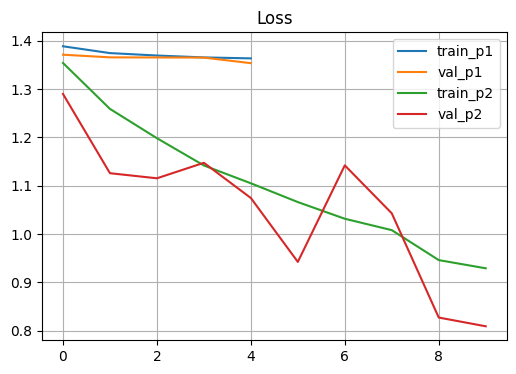

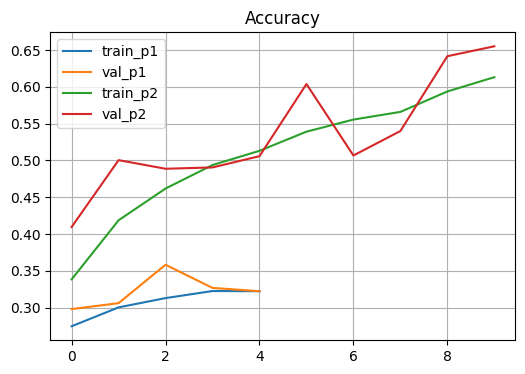

In [9]:
# ==== 6) Curves ====
def plot_curve(hlist, key):
    plt.figure(figsize=(6,4))
    for i,h in enumerate(hlist):
        plt.plot(h.history.get(key, []), label=f"train_p{i+1}")
        plt.plot(h.history.get("val_"+key, []), label=f"val_p{i+1}")
    plt.title(key.capitalize()); plt.legend(); plt.grid(True); plt.show()

plot_curve([history_p1, history_p2], "loss")
plot_curve([history_p1, history_p2], "accuracy")


[Model 3] Test - loss: 0.9879  acc: 0.6047
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 758ms/step
                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT     0.5157    0.4863    0.5006       438
       HEALTHY_LEAF     0.5880    0.7967    0.6766       541
        LEAF_BLIGHT     0.7372    0.6588    0.6958       724
PHOMOPSIS_LEAF_SPOT     0.4873    0.3787    0.4262       404

           accuracy                         0.6047      2107
          macro avg     0.5821    0.5801    0.5748      2107
       weighted avg     0.6049    0.6047    0.5986      2107



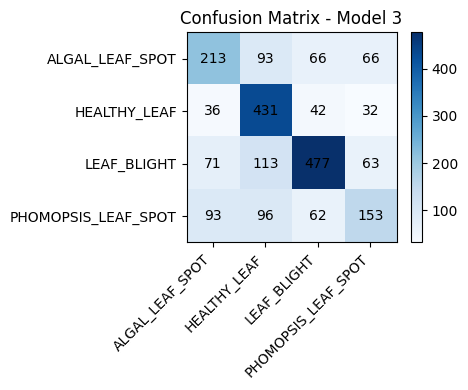

In [10]:
# ==== 7) Evaluate บนชุด test & รายงานผล ====
best_model = keras.models.load_model(BEST)  # (เราใช้ Rescaling จึงโหลดตรงๆได้)
test_loss, test_acc = best_model.evaluate(test_data, verbose=0)
print(f"[Model 3] Test - loss: {test_loss:.4f}  acc: {test_acc:.4f}")

# พยากรณ์ทั้ง test set
probs = best_model.predict(test_data, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = test_data.classes

# ทำ label ชื่อคลาสตาม index
idx2name = {v:k for k,v in train_data.class_indices.items()}
target_names = [idx2name[i] for i in range(NUM_CLASSES)]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix - Model 3"); plt.colorbar()
plt.xticks(range(NUM_CLASSES), target_names, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES), target_names)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


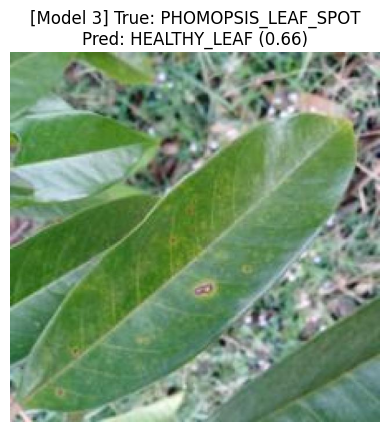

Class order: ['ALGAL_LEAF_SPOT', 'HEALTHY_LEAF', 'LEAF_BLIGHT', 'PHOMOPSIS_LEAF_SPOT']
ALGAL_LEAF_SPOT        : 0.162
HEALTHY_LEAF           : 0.661
LEAF_BLIGHT            : 0.007
PHOMOPSIS_LEAF_SPOT    : 0.170


In [24]:
# ==== 8) ทำนาย "สุ่มภาพ" จากโฟลเดอร์ test เพื่อโชว์ผล ====
import os, random
from tensorflow.keras.preprocessing import image
from PIL import Image

def random_image_path(root):
    class_dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    cls = random.choice(sorted(class_dirs))
    files = [f for f in os.listdir(os.path.join(root, cls))
             if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]
    img_name = random.choice(files)
    return os.path.join(root, cls, img_name), cls

def preprocess_pil(img, size=IMG):
    x = np.array(img.convert("RGB").resize(size)).astype("float32")
    x = x/127.5 - 1.0
    return np.expand_dims(x, 0)

# ทำนาย 1 รูป
img_path, true_cls = random_image_path(test_dir)
img = Image.open(img_path)
pp = best_model.predict(preprocess_pil(img), verbose=0)[0]
pred_idx = int(np.argmax(pp))
pred_name = idx2name[pred_idx]
pred_prob = float(np.max(pp))

plt.imshow(img); plt.axis("off")
plt.title(f"[Model 3] True: {true_cls}\nPred: {pred_name} ({pred_prob:.2f})")
plt.show()

print("Class order:", target_names)
for i, p in enumerate(pp):
    print(f"{target_names[i]:22s} : {p:.3f}")


In [26]:
import os, json, time
from tensorflow import keras

EXP_DIR = "/content/drive/MyDrive/exp_model3_saved"
os.makedirs(EXP_DIR, exist_ok=True)

STAMP = time.strftime("%Y%m%d-%H%M%S")
KERAS_PATH  = f"{EXP_DIR}/best-{STAMP}.keras"     # รูปแบบใหม่ของ Keras 3
SAVEDMODEL  = f"{EXP_DIR}/savedmodel-{STAMP}"     # โฟลเดอร์ SavedModel
CLSMAP_PATH = f"{EXP_DIR}/class_indices.json"

# 1) บันทึกไฟล์ .keras (แนะนำใช้เป็นหลักสำหรับโหลดกลับด้วย Keras)
model_3.save(KERAS_PATH)
print("Saved .keras =>", KERAS_PATH)

# 2) (ทางเลือก) บันทึกเป็น SavedModel สำหรับ TF Serving / TFLite / ฯลฯ
#    ใน Keras 3 ให้ใช้ .export(<dir>) แทน save(..., save_format="tf")
model_3.export(SAVEDMODEL)
print("Saved SavedModel =>", SAVEDMODEL)

# 3) บันทึก mapping ชื่อคลาส -> ดัชนี
with open(CLSMAP_PATH, "w", encoding="utf-8") as f:
    json.dump(train_data.class_indices, f, indent=2, ensure_ascii=False)
print("Saved class_indices.json =>", CLSMAP_PATH)


Saved .keras => /content/drive/MyDrive/exp_model3_saved/best-20251017-111532.keras
Saved artifact at '/content/drive/MyDrive/exp_model3_saved/savedmodel-20251017-111532'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136850784977168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784981584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784979664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784980240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784980624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784981392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784979856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784981200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136850784976976: Tens

In [28]:
from tensorflow import keras, saved_model
import numpy as np

# 1) โหลดจาก .keras (แนะนำเวลาใช้งานทั่วไป)
m = keras.models.load_model("/content/drive/MyDrive/exp_model3_saved/best-20251017-111532.keras")
print("OK .keras:", m.input_shape, "->", m.output_shape)

# 2) โหลดจาก SavedModel (สำหรับ TF Serving/advanced use)
import tensorflow as tf
serving = tf.saved_model.load("/content/drive/MyDrive/exp_model3_saved/savedmodel-20251017-111532")
infer = serving.signatures["serving_default"]  # หรือ "serve"
x = tf.zeros([1,299,299,3], dtype=tf.float32)
y = infer(x)
print("OK SavedModel keys:", list(y.keys()))


OK .keras: (None, 299, 299, 3) -> (None, 4)
OK SavedModel keys: ['output_0']
